In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [295]:
df = pd.read_csv('weather_data.csv')

In [296]:
df = pd.DataFrame(df)

In [297]:
df.head(5)

,time,temp,wind_speed,wind_degree,pressure,precip,humidity,cloud,uv,weather
0,2024-10-22 00:00,26.1,7.9,179,29.86,0.0,74,35,0.0,1003
1,2024-10-22 01:00,26.0,7.2,188,29.85,0.0,74,32,0.0,1003
2,2024-10-22 02:00,25.8,6.1,185,29.84,0.0,73,26,0.0,1003
3,2024-10-22 03:00,25.5,6.5,168,29.84,0.0,73,34,0.0,1003
4,2024-10-22 04:00,25.5,6.1,183,29.85,0.0,72,20,0.0,1000


In [298]:
df.duplicated().sum()

0

In [299]:
training = df.drop(['time', 'weather', 'precip', 'uv'], axis=1)

In [300]:
training.head(5)

,temp,wind_speed,wind_degree,pressure,humidity,cloud
0,26.1,7.9,179,29.86,74,35
1,26.0,7.2,188,29.85,74,32
2,25.8,6.1,185,29.84,73,26
3,25.5,6.5,168,29.84,73,34
4,25.5,6.1,183,29.85,72,20


In [301]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(training)

In [302]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# train_scaled = scaler.fit_transform(training)

In [303]:
pd.DataFrame(train_scaled).head(5)

,0,1,2,3,4,5
0,0.272,0.378788,0.500000,0.807692,0.637931,0.35
1,0.264,0.343434,0.525140,0.769231,0.637931,0.32
2,0.248,0.287879,0.516760,0.730769,0.620690,0.26
3,0.224,0.308081,0.469274,0.730769,0.620690,0.34
4,0.224,0.287879,0.511173,0.769231,0.603448,0.20


In [304]:
def create_sequences(data, sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):
        X.append(data[i:i + sequence_length, :])
        y.append(data[i + sequence_length:i + sequence_length + forecast_horizon, :])
        
    return np.array(X), np.array(y)

In [305]:
sequence_length = 6
forecast_horizon = 1

X, y = create_sequences(train_scaled, sequence_length, forecast_horizon)

In [306]:
split_ratio = 0.8
split = int(split_ratio * len(X))

x_train, x_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [437]:
num_features = X.shape[2]

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(sequence_length, num_features)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True)),
#     tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', return_sequences=True)),
#     tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, activation='tanh', return_sequences=False)),
#     tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='tanh', return_sequences=False)),
#     # tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation='relu'),
#     # tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(64, activation='relu'),
#     # tf.keras.layers.Dropout(0.2),
#     # tf.keras.layers.Dense(32, activation='relu'),
#     # tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(num_features * forecast_horizon),
#     tf.keras.layers.Reshape((forecast_horizon, num_features))
# ])

model = tf.keras.Sequential([    
    tf.keras.layers.Input(shape=(sequence_length, num_features)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(192, return_sequences=False)),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=False)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=False)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(192, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_features * forecast_horizon),  
    tf.keras.layers.Reshape((forecast_horizon, num_features))
])

model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), loss='mae', metrics=['mae'])

In [438]:
init_weights = model.get_weights()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 6, 512)           405504    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 6, 512)           2048      
 ormalization)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 384)              813312    
 nal)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 384)              1536      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 192)               7

In [439]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor = 0.5, patience=4, min_lr=1e-6)

In [440]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs):
        if logs['mae'] <= 0.058 and logs['val_mae'] <= 0.058:
            self.model.stop_training = True

custom_early_stopping = CustomEarlyStopping()

In [441]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [442]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[custom_early_stopping])
# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[reduce_lr])

Epoch 1/100
38/38 [==============================] - 11s 98ms/step - loss: 4.8172 - mae: 0.2839 - val_loss: 4.5865 - val_mae: 0.3739
Epoch 2/100
38/38 [==============================] - 2s 64ms/step - loss: 4.0722 - mae: 0.1658 - val_loss: 3.9487 - val_mae: 0.3490
Epoch 3/100
38/38 [==============================] - 2s 57ms/step - loss: 3.4673 - mae: 0.1289 - val_loss: 3.3902 - val_mae: 0.3124
Epoch 4/100
38/38 [==============================] - 2s 58ms/step - loss: 2.9617 - mae: 0.1061 - val_loss: 2.9297 - val_mae: 0.2960
Epoch 5/100
38/38 [==============================] - 2s 58ms/step - loss: 2.5384 - mae: 0.0941 - val_loss: 2.5241 - val_mae: 0.2691
Epoch 6/100
38/38 [==============================] - 2s 56ms/step - loss: 2.1808 - mae: 0.0877 - val_loss: 2.1734 - val_mae: 0.2419
Epoch 7/100
38/38 [==============================] - 2s 58ms/step - loss: 1.8758 - mae: 0.0826 - val_loss: 1.8782 - val_mae: 0.2233
Epoch 8/100
38/38 [==============================] - 2s 58ms/step - loss: 1

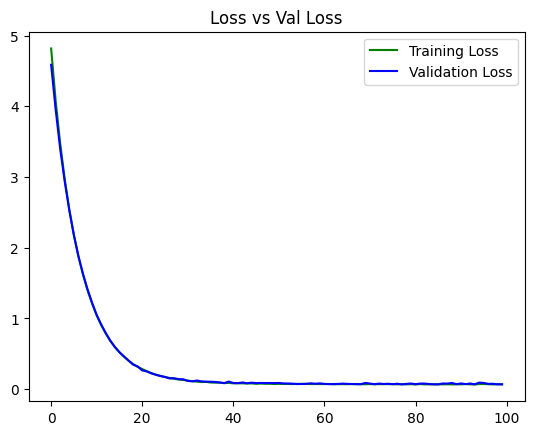

In [443]:
plt.plot(history.history['loss'], color='g', label='Training Loss')
plt.plot(history.history['val_loss'], color='b', label='Validation Loss')
plt.title("Loss vs Val Loss")
plt.legend()
plt.show()

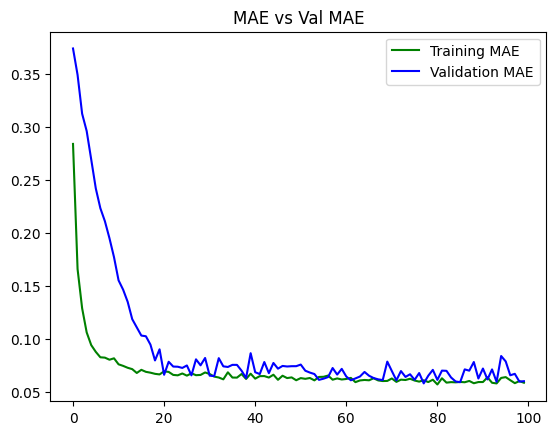

In [444]:
plt.plot(history.history['mae'], color='g', label='Training MAE')
plt.plot(history.history['val_mae'], color='b', label='Validation MAE')
plt.title("MAE vs Val MAE")
plt.legend()
plt.show()

In [445]:
loss, mae = model.evaluate(x_test, y_test, verbose=0)
print("Loss : {}, MAE : {}".format(loss, mae))

Loss : 0.0700024962425232, MAE : 0.060055334120988846


In [446]:
predictions = model.predict(x_test)

print(scaler.inverse_transform(predictions[2]))
print(scaler.inverse_transform(y_test[2]))

5/5 [==============================] - 2s 49ms/step
[[30.535355 11.833615 50.175465 29.699614 64.868904 81.711174]]
[[30.2  12.6  35.   29.69 64.   80.  ]]


In [447]:
# model.save('forecasting.h5')